<a href="https://colab.research.google.com/github/CharlesAntoineVouligny/DeepLearning-with-PyTorch-Lightning/blob/main/FirstDeepLearning_ImageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages (p.38)

In [ ]:
%pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
%pip install pytorch-lightning==1.5.2 --quiet
%pip install opendatasets --upgrade --quiet

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:36tcmalloc: large alloc 1147494400 bytes == 0x3a466000 @  0x7fdfd495e615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 12 kB/s 
     |████████████████████████████████| 23.3 MB 4.3 MB/s 
     |████████████████████████████████| 8.0 MB 6.2 MB/s 
     |████████████████████████████████| 2.9 MB 36.8 MB/s 
     |████████████████████████████████| 1.0 MB 9.0 MB/s 
     |████████████████████████████████| 596 kB 36.6 MB/s 
     |████████████████████████████████| 419 kB 49.9 MB/s 
     |████████████████████████████████| 829 kB 46.0 MB/s 
     |████████████████████████████████| 140 kB 45.9 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
     |██████

In [ ]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

In [ ]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


# Collect data (p.40)

    Kaggle Credentials
    --------------------------------------
    username : charlesavouligny
    key : 5af41fda95112216dda6290dcb66abfa

In [ ]:
dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: charlesavouligny
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [01:25<00:00, 78.9MB/s]



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


In [ ]:
cancer_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Prepare data

In [ ]:
# Downsampling the data (p.42)
# Get 10 000 images from the dataset
np.random.seed(5436)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

In [ ]:
# Split the extracted data in a training set and a testing set
np.random.seed(5436)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


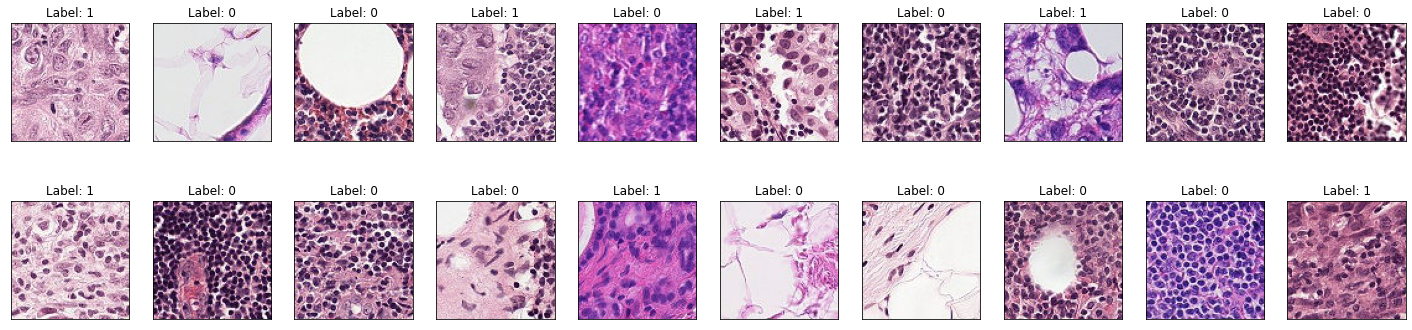

In [ ]:
# (What the data looks like - purely informal)
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:
# Transfer local data to persistent storage
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Process data online - train dataset
os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/train_dataset/")))

No. of images in downsampled training dataset:  7864


In [ ]:
# Process data online - test dataset
